# Paysage de fitness

sur Graph Coloring Problem et Weighted Vertex Coloring Problem sur l'instance DSJC500.5.

A tester pour :

- $s_{i+1} \in N(s_i)$ en partant d'une solution totalement aléatoire
- $s_{i+1} \in N_{tabu\_search}(s_i)$ en partant d'une solution de très bonne qualité

X = 1_000_000_000

| #it | fit   | sol   |
| --- | ----- | ----- |
| $i$ | $f_i$ | $s_i$ |
| ... | ...   | ...   |
| $X$ | $f_x$ | $s_X$ |

K=20 ~ 100

3 mesures pour (1) et (2) :

- autocorrélation : $autocorrelation([f_i | i \in {1...X-K}], [f_i | i \in K+1...X]) $
- neutralité : $\frac{\mathcal{1|} (f_i = fi+K)}{X-K}$ vérification de la neutralité à une distance de K
- distances : $1-\frac{\frac{\sum_{i=1}^{X-K} d(s_i, s_{i+K})}{X-K}}{K}$ à partir du moment où cette valeur augmente trop quand K augmente, alors la fiabilité des autres mesures n'est plus à prendre en compte.


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm

sns.set_theme()


def plot(file, title):
    data = pd.read_csv(file)[["fit"]]
    x = data.fit.to_numpy()

    nlags = 500
    acorr = sm.tsa.acf(x, nlags=nlags)

    plt.ylim(0, 1)
    plt.xlim(1,nlags)
    plt.plot(acorr)
    plt.title(f"Autocorrelation {title}")
    plt.show()

    neutrality = [0] * nlags

    for k in range(nlags - 1):
        n = 1
        if k > 0:
            tmp = [x[i] == x[i + k] for i in range(len(x) - k)]
            n = sum(tmp) / (len(x) - k)
        neutrality[k] = n

    plt.ylim(0, 1)
    plt.xlim(1,nlags)
    plt.plot(neutrality)
    plt.title(f"Neutrality {title}")
    plt.show()


def distance(col1, col2):
    max_k: int = max(max(col1), max(col2)) + 1
    same_color = [[0] * max_k for _ in range(max_k)]
    for vertex in range(len(col1)):
        same_color[col1[vertex]][col2[vertex]] += 1
    corresponding_color = [0] * max_k

    proxi = 0

    for c in range(max_k):
        max_val = -1
        max_c1 = -1
        max_c2 = -1
        for c1 in range(max_k):
            max_val_tmp = max(same_color[c1])
            if max_val_tmp > max_val:
                max_val = max_val_tmp
                max_c1 = c1
                max_c2 = same_color[c1].index(max_val_tmp)
        corresponding_color[max_c1] = max_c2
        proxi += max_val
        same_color[max_c1] = [-1] * max_k
        for i in range(max_k):
            same_color[i][max_c2] = -1
    return len(col1) - proxi


def get_distances(i: int, j: int, dists: dict[int, dict[int]], x):
    if i in dists:
        if j in dists[i]:
            return dists[i][j]
    elif j in dists:
        if i in dists[j]:
            return dists[i][j]
    else:
        dists[i] = {}
    dists[i][j] = distance(x[i], x[j])
    return dists[i][j]


def plot_dist(file, title):
    data = pd.read_csv(file)[["solution"]]
    print("loaded")
    x = data["solution"].to_numpy()[:10000]
    print("converted")
    x = [list(map(int, s.split(":"))) for s in x]
    print("splitted")
    nlags = 500

    dist = [0] * nlags
    dists = {}

    for k in tqdm(range(nlags - 1)):
        d = 1
        if k > 0:
            tmp = sum([get_distances(i, i + k, dists, x) for i in range(len(x) - k)])
            d = tmp / (len(x) - k) / k
        dist[k] = d

    plt.ylim(0, 1)
    plt.xlim(1,nlags)
    plt.plot(dist)
    plt.title(f"Distance {title}")
    plt.show()


In [2]:
from sklearn import manifold

data = pd.read_csv("wvcp_DSJC500.5_tabu_weight_dist.csv")[["solution"]][::1000]
x = data["solution"].to_numpy()
x = [list(map(int, s.split(":"))) for s in x]
nb_sols = len(x)
dists = {}
matrix = [[0] * nb_sols for _ in range(nb_sols)]
for i in range(nb_sols):
    for j in range(i + 1, nb_sols):
        matrix[i][j] = matrix[j][i] = distance(x[i], x[j])


/home/user/Documents/phd/code/gc_wvcp_adaptive_mcts/venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/user/Documents/phd/code/gc_wvcp_adaptive_mcts/venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


1943057201.5717895
[[ -895.74767107  -332.40670024  -574.48476351]
 [-1035.5835146   -327.76883972  -738.28258709]
 [ -861.82675142  -344.57306822  -708.81744632]
 ...
 [ 1070.84787824  -358.98961844  -102.15468712]
 [ 1114.67958429  -193.37944127  -264.33015881]
 [ 1026.22087983  -333.23767043   -55.82713524]]


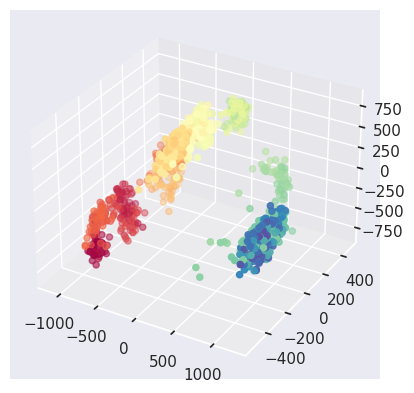

In [3]:

mds = manifold.MDS(n_components=3, dissimilarity="euclidean")

results = mds.fit(matrix)
print(mds.stress_)
coords = results.embedding_
print(coords)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], color=sns.color_palette("Spectral", len(x)))
plt.show()

In [4]:
import plotly
import plotly.graph_objs as go


trace = go.Scatter3d(
    x=coords[:, 0],
    y=coords[:, 1],
    z=coords[:, 2],
    mode="markers",
    marker={
        "size": 10,
        "opacity": 0.8,
        "color":sns.color_palette("rocket", len(x))
    },
)

# Configure the layout.
layout = go.Layout(margin={"l": 0, "r": 0, "b": 0, "t": 0})

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

In [5]:
plot_figure.write_html("landscape_wvcp.html")

In [49]:
data = pd.read_csv("wvcp_DSJC500.5_tabu_weight_dist.csv")[["fit","nb_colors"]][::1000]

In [51]:
import plotly
import plotly.graph_objs as go


trace = go.Scatter3d(
    x=list(range(len(data))),
    # x=[0] * len(data),
    y=data["fit"],
    z=data["nb_colors"],
    mode="markers",
    marker={
        "size": 10,
        "opacity": 0.8,
        "color":sns.color_palette("rocket", len(scores))
    },
)

# Configure the layout.
layout = go.Layout(margin={"l": 0, "r": 0, "b": 0, "t": 0})

data_ = [trace]

plot_figure = go.Figure(data=data_, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

In [41]:
pd.read_csv("wvcp_DSJC500.5_tabu_weight_dist.csv")

,turn,score,%improve,%regress,%neutral,nb_colors,penalty,fit,solution
0,1000001,0,0.0,0.958296,0.041704,67,0,767,0:1:0:2:3:3:0:2:3:2:5:3:1:6:5:4:5:6:6:6:5:6:7:...
1,1000002,0,0.0,0.957967,0.042033,67,0,767,0:1:0:2:3:3:0:2:3:2:5:3:1:6:5:4:5:6:6:6:5:6:7:...
2,1000003,0,0.0,0.951368,0.048632,67,0,767,0:1:0:2:3:3:0:2:3:2:5:3:1:6:5:4:5:6:6:6:5:6:7:...
3,1000004,0,0.0,0.950000,0.050000,67,0,767,0:1:0:2:3:3:0:2:3:2:5:3:1:6:5:4:5:6:6:6:5:6:7:...
4,1000005,0,0.0,0.952048,0.047952,67,0,767,0:1:0:2:3:3:0:2:3:2:5:3:1:6:5:4:5:6:6:6:5:6:7:...
...,...,...,...,...,...,...,...,...,...
999995,1999996,0,0.0,0.943599,0.056401,68,0,772,0:1:0:2:3:3:0:2:3:2:5:3:1:6:5:4:5:6:6:6:5:6:7:...
999996,1999997,0,0.0,0.942857,0.057143,68,0,772,0:1:0:2:3:3:0:2:3:2:5:3:1:6:5:4:5:6:6:6:5:6:7:...
999997,1999998,0,0.0,0.943734,0.056266,68,0,772,0:1:0:2:3:3:0:2:3:2:5:3:1:6:5:4:5:6:6:6:5:6:7:...
999998,1999999,0,0.0,0.944014,0.055986,68,0,772,0:1:0:2:3:3:0:2:3:2:5:3:1:6:5:4:5:6:6:6:5:6:7:...


In [4]:
import pandas as pd
data = pd.read_csv("gcp_DSJC500.5_tabu_col_dist.csv")[["fit","nb_colors"]][::1000]

import plotly
import plotly.graph_objs as go
import seaborn as sns

trace = go.Scatter3d(
    x=list(range(len(data))),
    # x=[0] * len(data),
    y=data["fit"],
    z=data["nb_colors"],
    mode="markers",
    marker={
        "size": 10,
        "opacity": 0.8,
        "color":sns.color_palette("rocket", len(data["fit"]))
    },
)

# Configure the layout.
layout = go.Layout(margin={"l": 0, "r": 0, "b": 0, "t": 0})

data_ = [trace]

plot_figure = go.Figure(data=data_, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

In [18]:
import plotly.express as px
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()


In [6]:
# plot("gcp_DSJC500.5_random_walk_dist.csv", "GCP Random Walk")
# plot("wvcp_DSJC500.5_random_walk_dist.csv", "WVCP Random Walk")
# plot("gcp_DSJC500.5_tabu_col_dist.csv", "GCP Tabu Col")
# plot("wvcp_DSJC500.5_tabu_weight_dist.csv", "WVCP Tabu Weight")


In [7]:
# plot_dist("gcp_DSJC500.5_random_walk_dist.csv", "GCP Random Walk")
# plot_dist("wvcp_DSJC500.5_random_walk_dist.csv", "WVCP Random Walk")
# plot_dist("gcp_DSJC500.5_tabu_col_dist.csv", "GCP Tabu Col")
# plot_dist("wvcp_DSJC500.5_tabu_weight_dist.csv", "WVCP Tabu Weight")
